In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import distance_restr

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed
from random import randint

tools.hide_toggle()

# Compare DCA and ER Sensitivity
* ER does better than traditional methods with small sample size
* Want to analyse a Protein family with large number of sequences to test sensitivity
    * DCA paper uses PF00071 and PF04542

## PF04542

#### Read In Protein Structure

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF04542'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Print PDB array 
#print(pdb)
#print(pdb[0])

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

ipdb = 0
print('seq:',int(pdb[ipdb,1]))

from data_processing import data_processing
# data processing
s0,cols_removed,s_index = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

#print("Removed columns: ",cols_removed)


tools.hide_toggle()

number of pdb structures: 372
seq: 69


#### Process Protein Data
* Want to implement some changes to original code
    * Enforce AA distance requirement &rightarrow; |i-j|>5 (done)
    * Now we want to consider 25% 50% and 100% of available sequences

#### Only Use 25% of Available sequences

In [3]:
percent_keep = [.25,.5,1]
s0s = []
for ii, pk in enumerate(percent_keep):
    s0s.append(s0)
    # Select 25% of available sequences
    print("s0s[%d] shape: "%ii, s0s[ii].shape)
    n_seq = int(s0s[ii].shape[0] * pk)
    seq_cancel = s0s[ii].shape[0] - n_seq

    print("Using %d of %d sequences (removing %d)"%(n_seq,s0s[ii].shape[0],seq_cancel))

    for d in range(seq_cancel):
        s0s[ii] =np.delete(s0s[ii],randint(0,s0s[ii].shape[0]-1),axis=0)

    print("s0s[%d] shape: "%ii,s0s[ii].shape)


# number of positions
n_var = s0.shape[1]

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

# number of variables
mx_sum = mx.sum()

# number of bias term
n_linear = mx_sum - n_var

tools.hide_toggle()

s0s[0] shape:  (6734, 137)
Using 1683 of 6734 sequences (removing 5051)
s0s[0] shape:  (1683, 137)
s0s[1] shape:  (6734, 137)
Using 3367 of 6734 sequences (removing 3367)
s0s[1] shape:  (3367, 137)
s0s[2] shape:  (6734, 137)
Using 6734 of 6734 sequences (removing 0)
s0s[2] shape:  (6734, 137)


#### Generate OneHot Encoded Sequence (s0 &rightarrow; s)

In [4]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s_onehot = []
for s0 in s0s:
    s_onehot.append(onehot_encoder.fit_transform(s0))
#print("Amino Acid sequence Matrix\n",s0)
#print("OneHot sequence Matrix\n",s)
#print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)
print(s_onehot)
tools.hide_toggle()

[array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]]), array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]]), array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])]


#### Use Expectation Reflection to infer w, and H
* I want to start saving these files to read in (save on computation time)

In [5]:
dis = []

for ii, s in enumerate(s_onehot):
    # Define wight matrix with variable for each possible amino acid at each sequence position
    w = np.zeros((mx.sum(),mx.sum())) 
    h0 = np.zeros(mx.sum())

    # Expectation Reflection
    # Expectation Reflection
    #=========================================================================================
    def predict_w(s,i0,i1i2,niter_max,l2):
        #print('i0:',i0)
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        x = np.hstack([s[:,:i1],s[:,i2:]])
        y = s[:,i1:i2]

        h01,w1 = ER.fit(x,y,niter_max,l2)

        return h01,w1

    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    #----------------niter_max,l2)
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.

    # Calculate Direct Information from infered weights and Original Sequence Data
    dis.append(direct_info(s0s[ii],w))

tools.hide_toggle()

run time: 39.23388225000235


/home/eclay/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


run time: 63.18945328598784
run time: 115.64235557800566


In [6]:
dis_save = np.asarray(dis)
np.save("dis_sensitivity.npy", dis_save)

#### Calculate Direct Information and Plot against Contact Map

In [7]:
from inference_dca import direct_info_dca

# Calculate Direct Information from infered weights and Original Sequence Data
dis_DCA = []
for s0 in s0s:
    dis_DCA.append(direct_info_dca(s0))

Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 


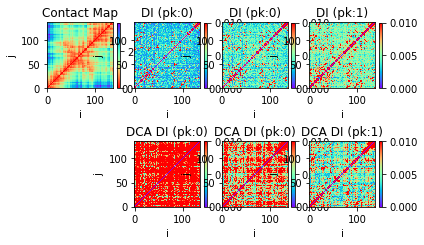

In [8]:
ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)



#DCA_di_distal = distance_restr(DCA_di,s_index)

# Plot Contact Map and Direct Information 
plt.subplot2grid((2,len(dis)+1),(0,0))
plt.title('Contact Map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045,pad=0.05)
for kk, di in enumerate(dis):
    plt.subplot2grid((2,len(dis)+1),(0,1+kk))
    plt.title('DI (pk:%d)'%percent_keep[kk])
    plt.imshow(di,cmap='rainbow',origin='lower')
    plt.xlabel('i')
    plt.ylabel('j')
    plt.clim(0,0.01)
    plt.colorbar(fraction=0.045, pad=0.05)
    
    plt.subplot2grid((2,len(dis)+1),(1,1+kk))
    plt.title('DCA DI (pk:%d)'%percent_keep[kk])
    plt.imshow(dis_DCA[kk],cmap='rainbow',origin='lower')
    plt.xlabel('i')
    plt.ylabel('j')
    plt.clim(0,0.01)
    plt.colorbar(fraction=0.045, pad=0.05)

#plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

tools.hide_toggle()

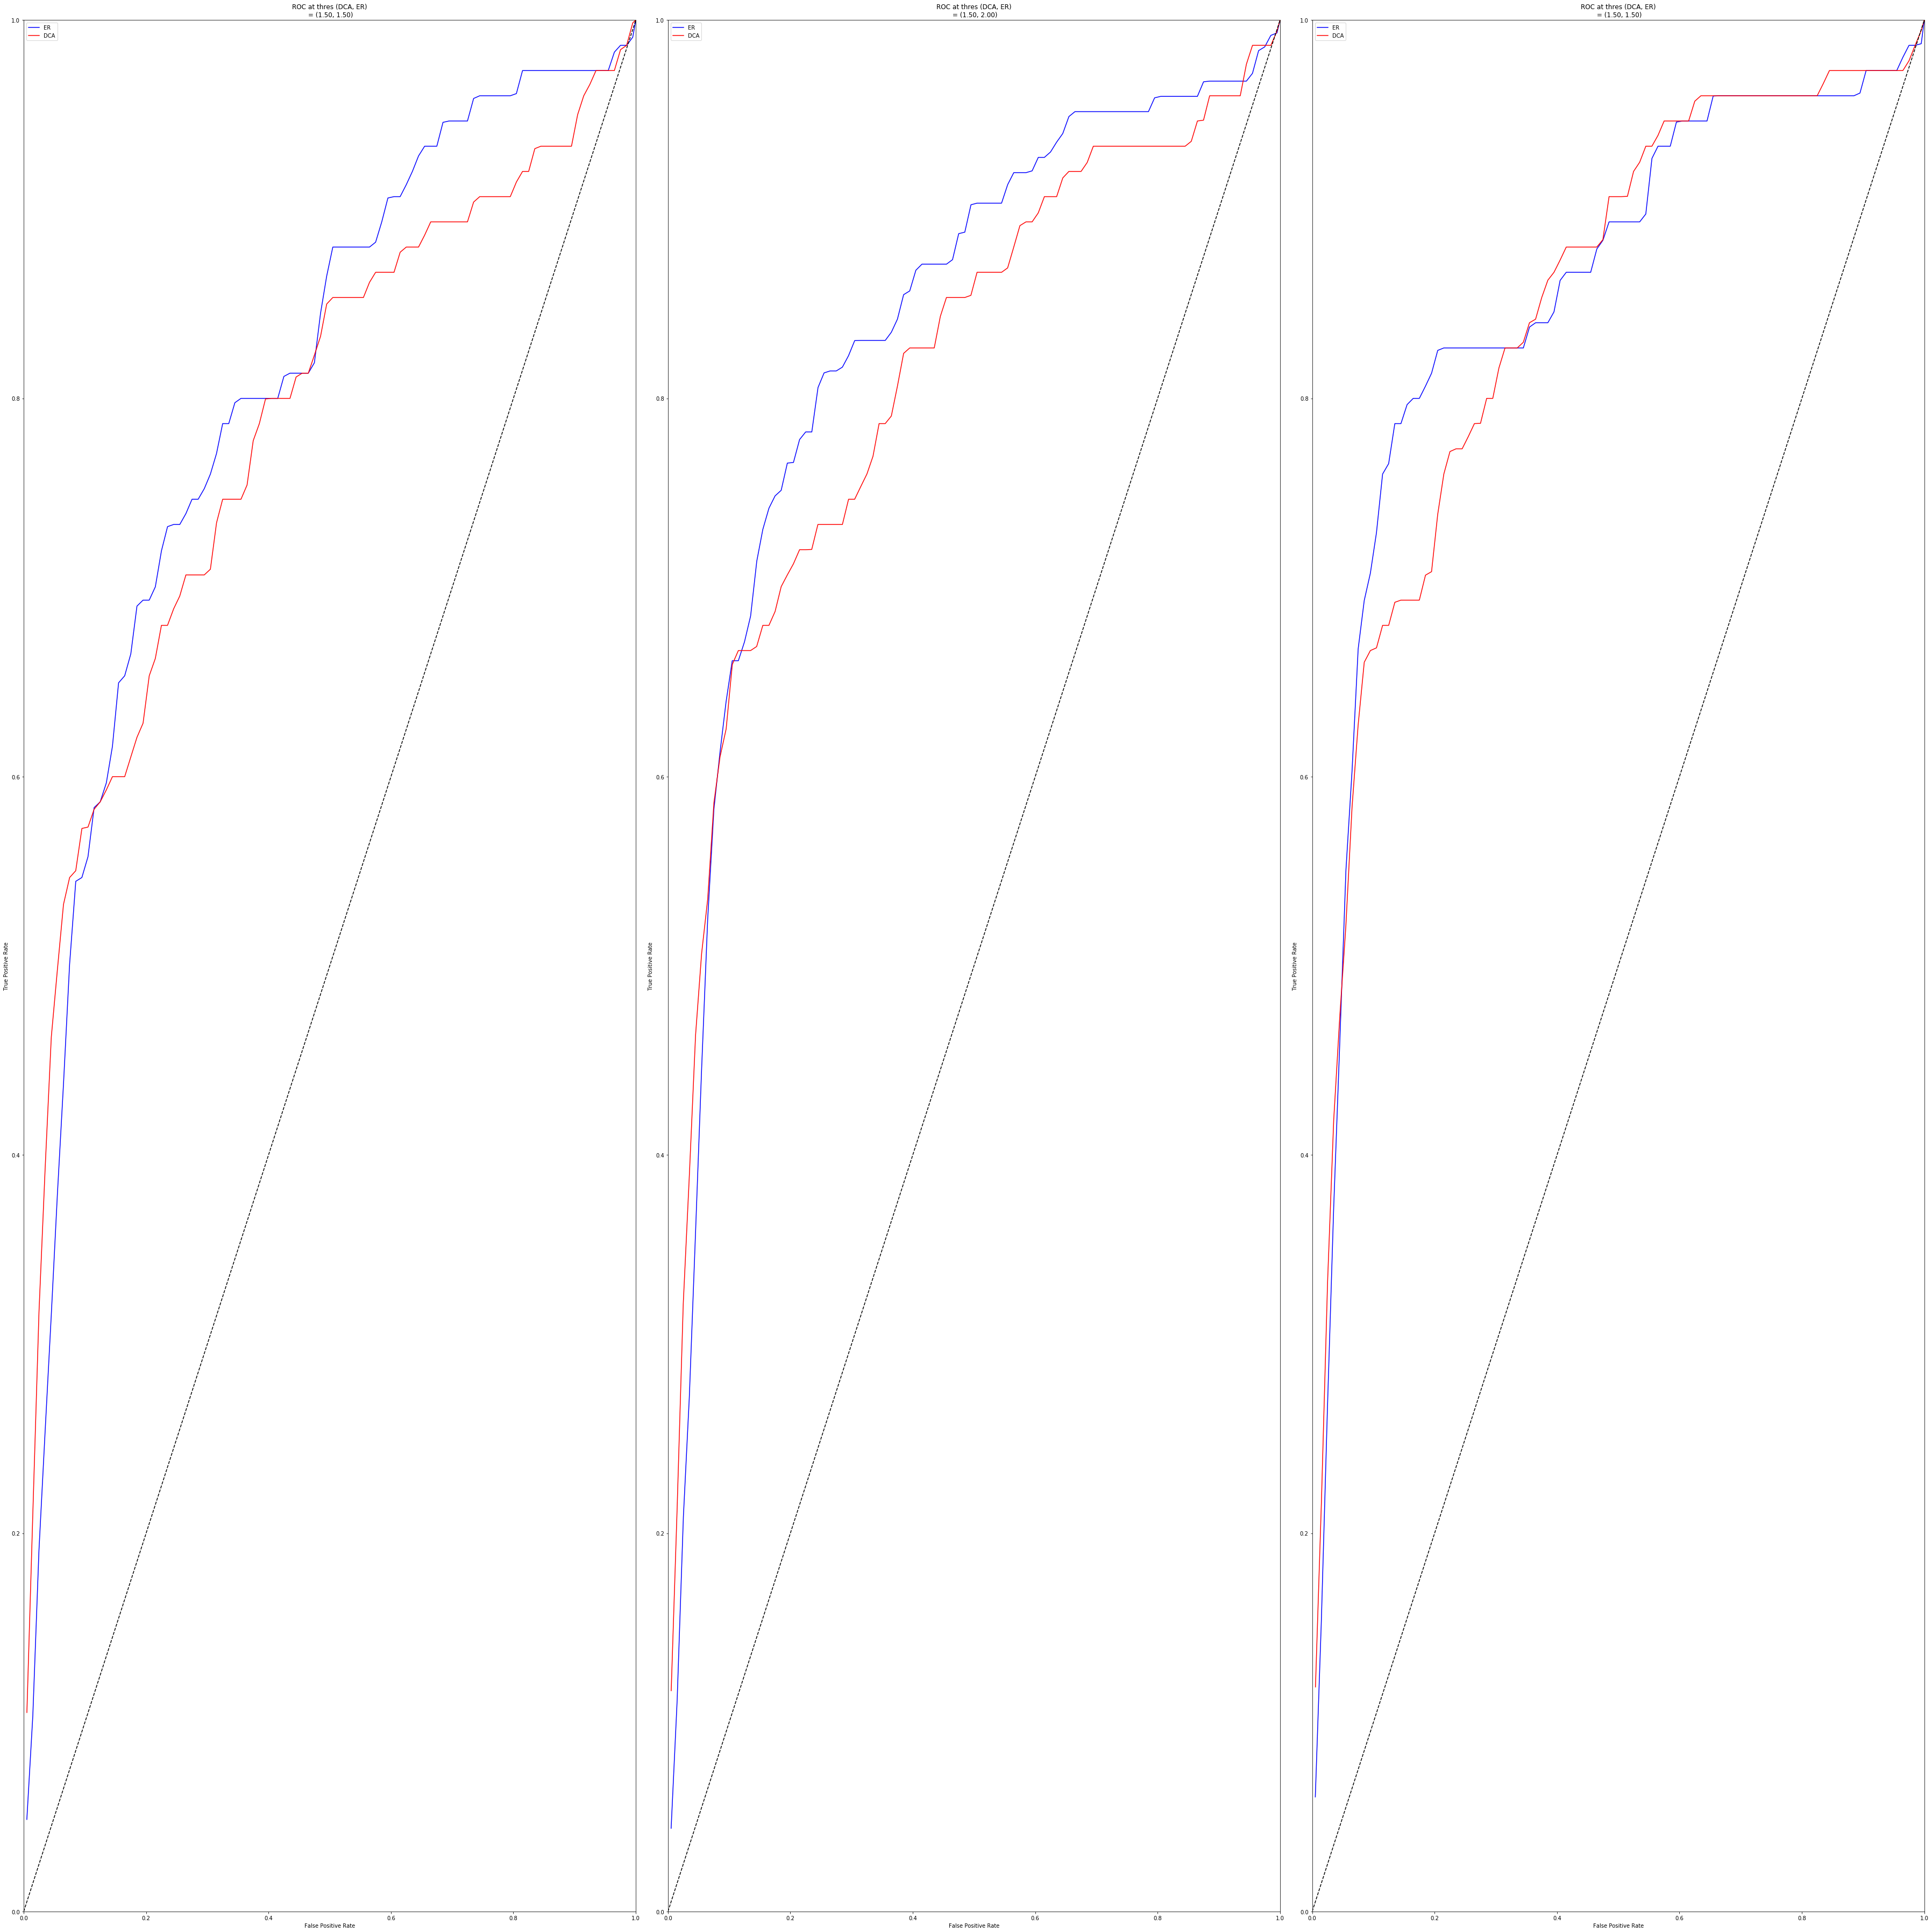

In [19]:
# Define values for finding optimal contact threshold
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

plt.rcParams['figure.figsize'] = [50, 50]

for ii, di in enumerate(dis):
    auc_DCA = np.zeros(n)
    auc_ER = np.zeros(n)
    for i in range(n):
        # find optimal threshold of distance for both DCA and ER
        p,tp,fp = tools.roc_curve(ct,dis_DCA[ii],ct_thres[i])
        auc_DCA[i] = tp.sum()/tp.shape[0]

        p,tp,fp = tools.roc_curve(ct,di,ct_thres[i])
        auc_ER[i] = tp.sum()/tp.shape[0]
    
    # Set DCA and ER TP, FP and P values for optimal contact distance
    i0_DCA = np.argmax(auc_DCA)
    i0_ER = np.argmax(auc_ER)
    
    p0_DCA,tp0_DCA,fp0_DCA = tools.roc_curve(ct,dis_DCA[ii],ct_thres[i0_DCA])
    p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct,di,ct_thres[i0_ER])
    
    # Plot ROC for optimal DCA vs optimal ER
    plt.subplot2grid((1,3),(0,ii))
    plt.title('ROC at thres (DCA, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
    plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
    plt.plot(fp0_DCA,tp0_DCA,'r-',label="DCA")
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    """
    # Plot AUC for DCA and ER
    plt.subplot2grid((3,3),(1,ii))
    plt.title('AUC (DCA, ER) max\n = (%3.2f, %3.2f)' %(auc_DCA[i0_DCA], auc_ER[i0_ER]))
    plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
    plt.plot(ct_thres,auc_DCA,'b-',label="DCA")
    plt.plot(ct_thres,auc_ER,'r-',label="ER")
    plt.xlim([ct_thres.min(),ct_thres.max()])
    plt.ylim([0,max(auc_DCA.max(),auc_ER.max())+0.1])
    plt.xlabel('distance threshold')
    plt.ylabel('AUC')
    plt.legend()

    # Plot Precision of optimal DCA and ER
    plt.subplot2grid((3,3),(2,ii))
    plt.title('Precision at thres \n(DCA, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
    plt.plot( p0_DCA,tp0_DCA / (tp0_DCA + fp0_DCA),'r-',label='DCA thres = %s'%ct_thres[i0_DCA])
    plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER thres = %s'%ct_thres[i0_ER])
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall (Sensitivity - P)')
    plt.ylabel('Precision (PPV)')
    plt.legend()
    """
plt.tight_layout(h_pad=1, w_pad=1.5)
